In [1]:
%matplotlib inline

In [2]:
import glob
import os
import subprocess
import numpy as np
from scipy import ndimage
from scipy import signal
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage.transform import rotate
import time
import pylab as pl
from IPython import display
import librosa
import pickle

from PIL import Image
from resizeimage import resizeimage

### Convert pdf to png

Requires use of ImageMagick's convert command line tool

In [3]:
root_dir = 'score_data'
indir_pdf = root_dir + '/prepped_pdf' # directory containing pdfs of scores
outdir_png_root = root_dir + '/prepped_png' # root output directory for png files

In [ ]:
if not os.path.exists(outdir_png_root):
    os.mkdir(outdir_png_root)
pdf_files = glob.glob(indir_pdf + '/*.pdf')
for pdf_file in pdf_files:
    basename = os.path.splitext(os.path.basename(pdf_file))[0]
    curdir = outdir_png_root + '/' + basename
    if not os.path.exists(curdir):
        os.mkdir(curdir)
    pngout = curdir + '/' + basename + '.png' # will create <basename>-0.png, <basename>-1.png, etc
    subprocess.call(['convert', '-density', '300', '-alpha', 'remove', pdf_file, pngout])

### Helper functions

#### Reading in an image

In [4]:
def importImage(pngfile):
    img = ndimage.imread(pngfile, flatten=True)
    img = 1 - img/255.0 # make white -> 0, black -> 1
    return img

In [5]:
def showImage(X, sz = (12,12)):
    plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')

In [45]:
sample_png = 'score_data/prepped_png/mozart_kv333mv3_v3/mozart_kv333mv3_v3-1.png'

In [ ]:
I = importImage(sample_png)
print(len(I), len(I[0]))
showImage(I)

#### Rotate to ensure horizontal lines

In [ ]:
def rotateToHorizontal(img, lb=-.5, ub=.5, incr=.02, topN=40):
    bestscore = -np.inf
    bestTheta = 0
    for theta in np.arange(lb, ub, incr):
        imgRot = rotate(img,theta)
        rsums = np.sum(imgRot, axis=1)
        rsums_sorted = sorted(rsums)[::-1]
        curscore = np.sum(rsums_sorted[0:topN])
        if curscore > bestscore:
            bestscore = curscore
            bestTheta = theta
    result = rotate(img,bestTheta)
    return result, bestTheta

In [ ]:
Irot, theta = rotateToHorizontal(I)
showImage(Irot)

#### Cropping out whitespace

In [ ]:
def getBoundingBox(img, thresh=.01, buff=0.05):
    r = img.shape[0]
    c = img.shape[1]
    
    cmeans = np.mean(img, axis=0)
    cmean_thresh = np.max(cmeans) * thresh
    cidxs_above = np.argwhere(cmeans > cmean_thresh)
    col_start = cidxs_above[0][0]
    col_end = cidxs_above[-1][0]
    
    rmeans = np.mean(img, axis=1)
    rmean_thresh = np.max(rmeans) * thresh
    ridxs_above = np.argwhere(rmeans > rmean_thresh)
    row_start = ridxs_above[0][0]
    row_end = ridxs_above[-1][0]
    
    # add buffer to ignore clefs
    bufflen = np.int((col_end - col_start) * buff)
    col_start_adj = col_start + bufflen
    
    return (row_start, col_start_adj), col_end - col_start_adj, row_end - row_start

In [ ]:
def showImageWithBB(X, loc, w, h, sz=(12,12)):
    fig = plt.figure(figsize=sz)
    plt.imshow(1-X, cmap='gray')
    ax = fig.gca()
    rect = patches.Rectangle((loc[1],loc[0]), w, h, linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()  

In [ ]:
def getCropped(X):
    ll, w, h = getBoundingBox(X)
    return X[ll[0]:ll[0]+h,ll[1]:ll[1]+w]

2157 3105
3166


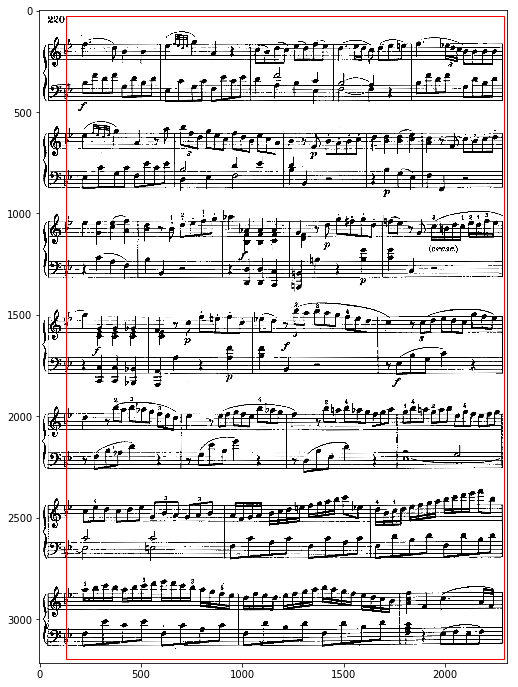

In [49]:
ll, bbw, bbh = getBoundingBox(Irot)
print(bbw, bbh)
bbh = 760 * 300 // 72
print(bbh)
showImageWithBB(Irot, ll, bbw, bbh)

#### Identifying strip boundaries

In [23]:
def getStripBoundaries(X, showPlot = False, threshold=0.2):
    
    # find staves
    filt = np.vstack((np.ones(21),np.zeros(21),-1*np.ones(21))) # emphasize horizontal lines
    Xfilt = signal.convolve2d(X-np.mean(X), filt, mode='same')
    rsum = np.sum(Xfilt, axis=1)
    rsum_new = []
    for i in range(rsum.shape[0]-4):
        rsum_new.append(sum(rsum[i:i+4]))
    rsum = np.array(rsum_new)
    rsum_spectra = librosa.core.stft(rsum,n_fft=32,hop_length=1) # look for high frequency oscillations
    spectra_max = np.max(rsum_spectra[4:10,:], axis=0)
    spectra_max_smoothed = np.convolve(spectra_max,np.hanning(15),'same')
    peakidxs = signal.find_peaks_cwt(spectra_max_smoothed, range(15,41,1))

    maxval = np.max(np.abs(spectra_max_smoothed))
    peakidxs_threshold = [peakidx for peakidx in peakidxs if 
                          np.abs(spectra_max_smoothed[peakidx])/maxval > threshold]
    peakidxs = peakidxs_threshold
    # determine boundaries
    numStrips = np.int(len(peakidxs)/2) - 1 
    boundaries = []
    for i in range(numStrips):
        peak1idx = peakidxs[2*i + 1]
        peak2idx = peakidxs[2*i + 2]
        midpt = np.int((peak1idx + peak2idx)/2.0)
        boundaries.append(midpt)
    boundaries.insert(0, 0)  # for first strip
    boundaries.append(X.shape[0]-1) # for last strip
    
    # show peak picking results (for debugging)
    if showPlot:
        plt.plot(spectra_max_smoothed)
        for pk in peakidxs:
            plt.axvline(x=pk, color='r', linewidth=1)
            
    return boundaries

In [24]:
def visualizeBoundaries(X, bnds, savefile = None):
    showImage(X)
    for bnd in bnds:
        plt.axhline(y=bnd, color='r', linewidth=1)
    if savefile:
        plt.savefig(savefile)

/home/mint/anaconda3/lib/python3.6/site-packages/scipy/signal/wavelets.py:364: ComplexWarning: Casting complex values to real discards the imaginary part
  mode='same')


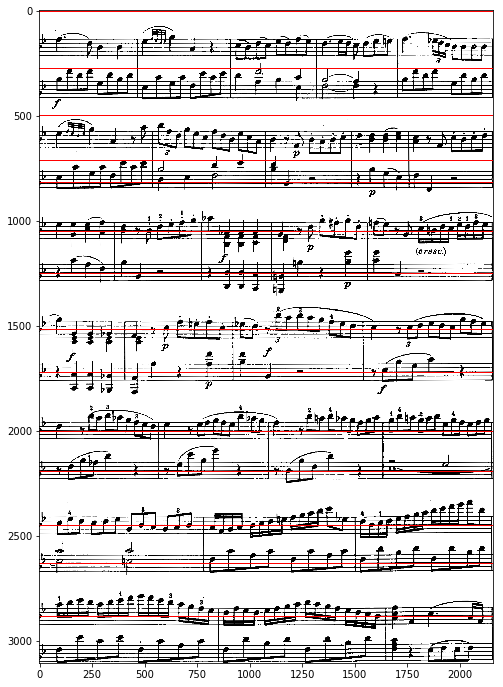

In [17]:
Icrop = getCropped(Irot)
bnds = getStripBoundaries(Icrop)
visualizeBoundaries(Icrop, bnds)

#### Visualize peak picking (debugging)

In [ ]:
pngfiles = glob.glob('score_data/prepped_png/*/*.png')
for pngfile in pngfiles:
    I = importImage(pngfile)
    Irot, theta = rotateToHorizontal(I)
    ll, bbw, bbh = getBoundingBox(Irot)
    Icrop = getCropped(Irot)
    bnds = getStripBoundaries(Icrop, True)
    plt.show()

#### Pulling out strips

In [26]:
def getStrips(X, bnds):
    strips = []
    for i in range(len(bnds)-1):
        rstart = bnds[i]
        rend = bnds[i+1] + 1 # include endpoint
        chunk = X[rstart:rend,:]
        strips.append(chunk)
    return strips

In [27]:
def showStrips(strips):
    for strip in strips:
        showImage(strip)

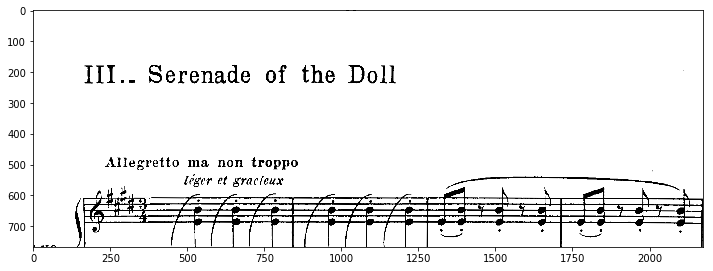

In [19]:
strips = getStrips(Icrop, bnds)
showImage(strips[0])

### Verify that strips are reasonable

#### Visualize predicted strip boundaries

In [20]:
def inspectBoundariesPre(filelist, outdir):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    predfile = outdir + '/bnds.predicted.txt' # text file with boundary predictions
    f = open(predfile,'w')
    for i, curfile in enumerate(filelist):
        
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        Icrop = getCropped(Irot)
        bnds = getStripBoundaries(Icrop)
        
        # generate images for inspection
        basename = os.path.splitext(os.path.basename(curfile))[0]
        outfile = '%s/%s.png' % (outdir,basename)
        #visualizeBoundaries(Icrop, bnds, outfile)
        
        # write to text file
        strOut = '%s %s\n' % (basename, ' '.join(map(str,bnds)))
        f.write(strOut)
        
    f.close()

In [24]:
png_files = sorted(glob.glob(outdir_png_root))
visualize_dir_pre = root_dir + '/visualize_boundaries_init'

In [ ]:
inspectBoundariesPre(png_files,visualize_dir_pre)

#### Manually correct predicted boundaries

First we manually removed strips corresponding to other pieces and corrected gross boundary prediction errors.  We then put the corrected boundary annotations in the file below.  Note that the annotations are done in the pixel space after rotating and cropping.

In [17]:
bndfile = root_dir + '/cfg_files/bnds.corrected.txt'

In [ ]:
bndfile = root_dir + '/visualize_boundaries_init/bnds.predicted.txt'

In [41]:
d = importBoundaryData(bndfile)
bnds = list(d["mozart_kv333mv3_v3-4"])

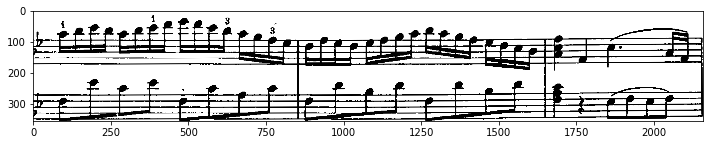

In [42]:
strips = getStrips(Icrop, bnds)
showImage(strips[6])

Do final visual verification

In [21]:
def importBoundaryData(infile):
    d = {}  # key: basename, val: list of boundaries locations
    with open(infile,'r') as f:
        for line in f:
            parts = line.split()
            basename = parts.pop(0)
            bnds = map(lambda x: int(x) * 300 // 72, parts)
            #bnds = map(lambda x: int(x) * 400 // (72*4), parts)
            #bnds = map(int, parts)
            d[basename] = bnds
    return d

In [26]:
def inspectBoundariesPost(filelist, outdir, bndsFile):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    d = importBoundaryData(bndsFile)
    for i, curfile in enumerate(filelist):
        
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        Icrop = getCropped(Irot)
        basename = os.path.splitext(os.path.basename(curfile))[0]
        bnds = d[basename]
        
        # generate images for inspection
        outfile = '%s/%s.png' % (outdir,basename)
        visualizeBoundaries(Icrop, bnds, outfile)        

In [23]:
visualize_dir_post = root_dir + '/visualize_boundaries_post'

/home/mint/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


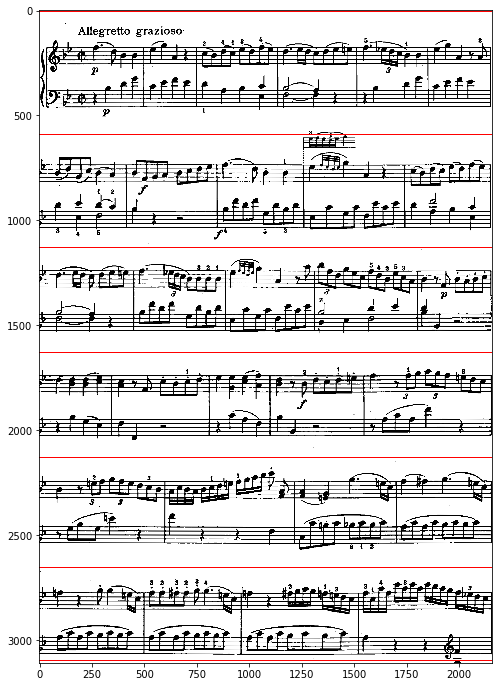

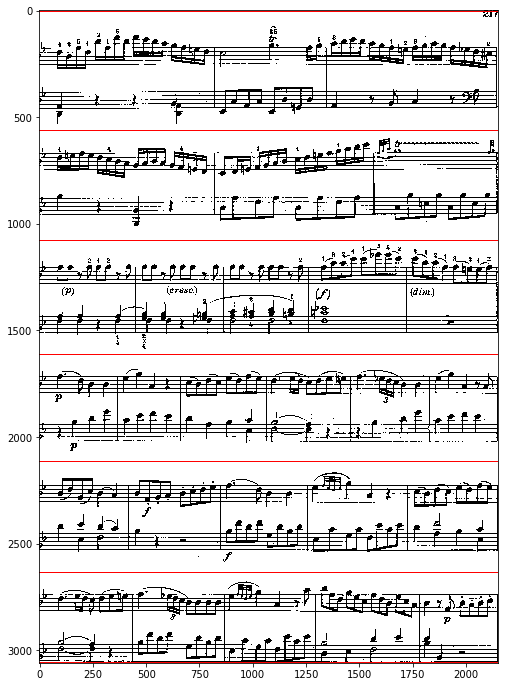

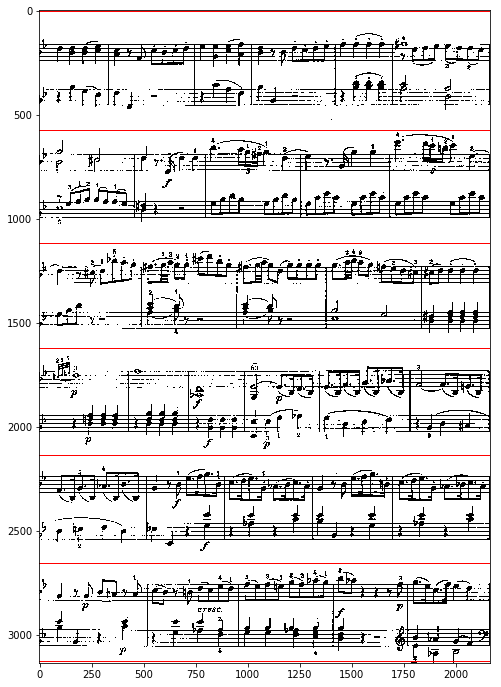

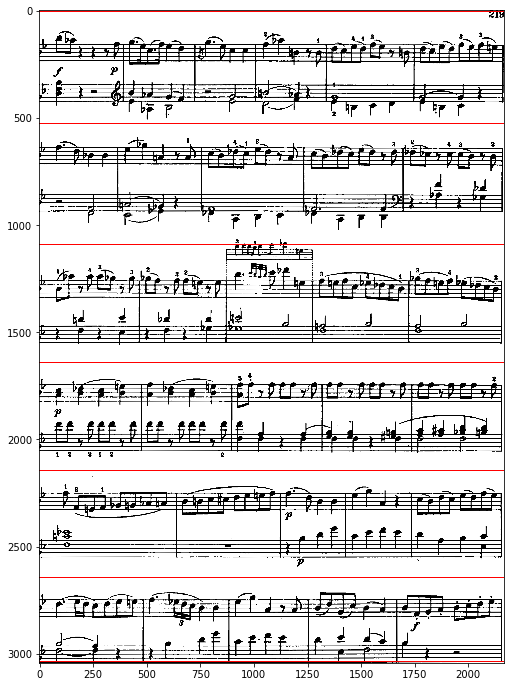

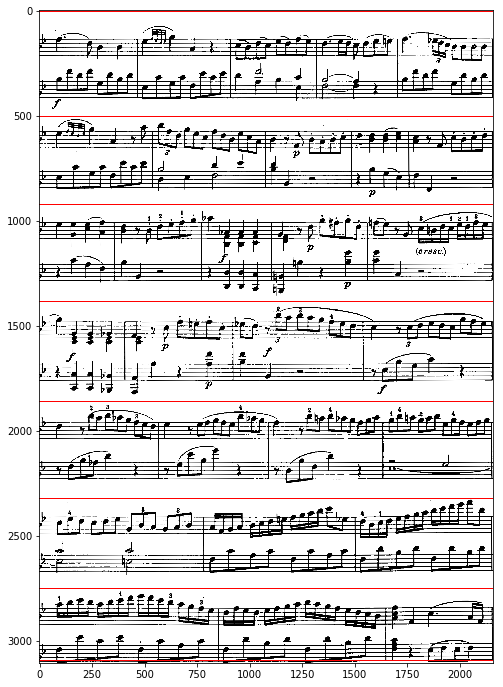

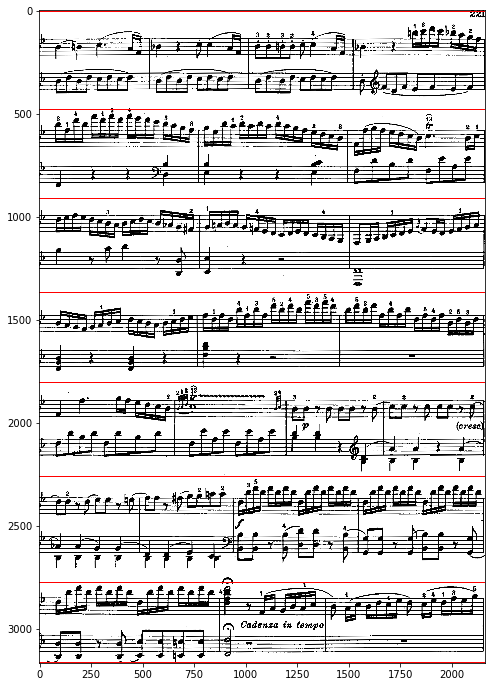

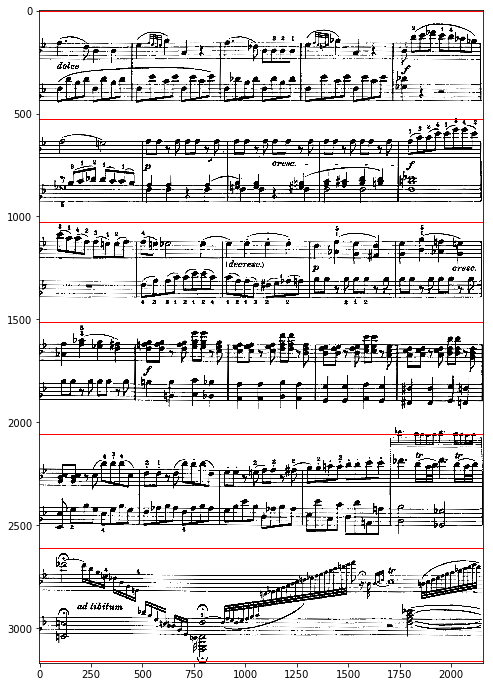

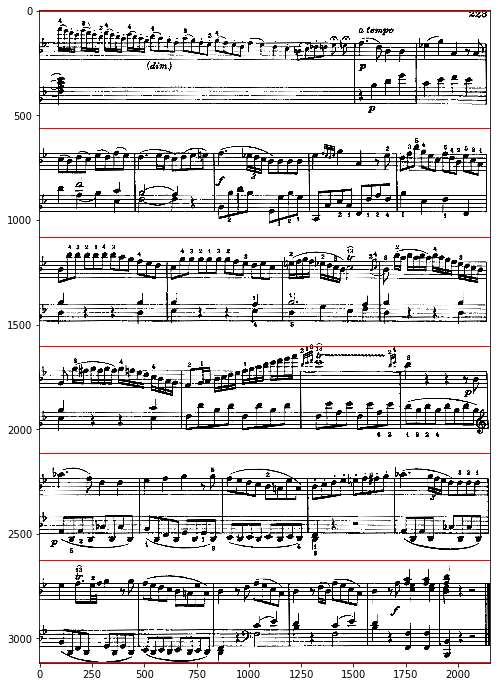

In [30]:
inspectBoundariesPost(png_files, visualize_dir_post, bndfile)

### Save processed strips to file

In [62]:
def saveResults(filelist, outdir, bndsFile):
    if not os.path.exists(outdir):
        os.mkdir(outdir)
    d = importBoundaryData(bndsFile)
    for i, curfile in enumerate(filelist):
        
        # get strip boundaries
        I = importImage(curfile)
        Irot, theta = rotateToHorizontal(I)
        ll, w, h = getBoundingBox(Irot)
        
        #Icrop = getCropped(Irot)
        Icrop = Irot[ll[0]:ll[0]+h,ll[1]:ll[1]+w]
        basename = os.path.splitext(os.path.basename(curfile))[0]
        bnds = list(d[basename])
        strips = getStrips(Icrop, bnds)
        
        # save to file
        outfile = '%s/%s.pkl' % (outdir,basename)
        data = {}
        data['I'] = I
        data['theta'] = theta
        data['bb'] = (ll, w, h)
        data['Icrop'] = Icrop
        data['basename'] = basename
        data['bnds'] = bnds
        data['strips'] = strips
        with open(outfile, 'wb') as f:
            pickle.dump(data, f)

In [55]:
pkl_dir = root_dir + '/pkl_data'

In [63]:
png_files = sorted(glob.glob(outdir_png_root))
saveResults(png_files, pkl_dir, bndfile)

/home/mint/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  
